In [1]:
%%capture
!pip install transformers


In [2]:
import pandas as pd
import torch
import numpy as np
from transformers import BertTokenizer, BertModel
from torch import nn
from torch.optim import Adam
from tqdm import tqdm

In [3]:
datapath = f'/Users/yaroslavkizyma/Desktop/json_data_exports_alternative/bert_data_overall.csv'
df = pd.read_csv(datapath)
df.head()

,category,text
0,refunds,Please go ahead and issue the refund. I don't ...
1,refunds,"Hello, the first Transaction ID is listed as ..."
2,refunds,"Hi Tania,\n\nHere is the other invoice I recei..."
3,refunds,Thank you for your quick reply. \nIt's not som...
4,refunds,Name: Hans Wieldraaijer\nEmail: hans.wiel@telf...


<AxesSubplot:xlabel='category'>

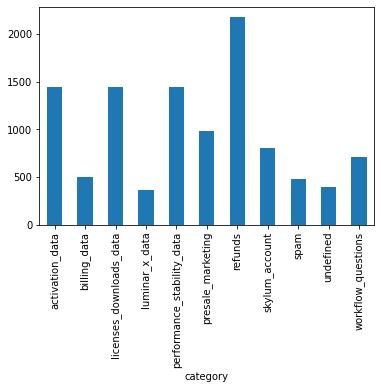

In [4]:
df.groupby(['category']).size().plot.bar()


In [50]:
tokenizer = BertTokenizer.from_pretrained('bert-base-cased')
labels = {'activation_data': 0, 
          'billing_data': 1,
          'licenses_downloads_data': 2,
          'luminar_x_data': 3,
          'performance_stability_data': 4,
          'presale_marketing': 5,
          'refunds': 6,
          'skylum_account': 7,
          'spam': 8,
          'undefined': 9,
          'workflow_questions': 10}

class Dataset(torch.utils.data.Dataset):

    def __init__(self, df):

        self.labels = [labels[label] for label in df['category']]
        # text.values instead of text
        self.texts = [tokenizer(str(text)[:512], 
                                # max length is 512 no matter the length of OG text, so we will truncate text nonetheless
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt") for text in df['text'].values.tolist()]

    def classes(self):
        return self.labels

    def __len__(self):
        return len(self.labels)

    def get_batch_labels(self, idx):
        # Fetch a batch of labels
        return np.array(self.labels[idx])

    def get_batch_texts(self, idx):
        # Fetch a batch of inputs
        return self.texts[idx]

    def __getitem__(self, idx):

        batch_texts = self.get_batch_texts(idx)
        batch_y = self.get_batch_labels(idx)

        return batch_texts, batch_y

In [51]:
class BertClassifier(nn.Module):

    def __init__(self, dropout=0.5):

        super(BertClassifier, self).__init__()

        self.bert = BertModel.from_pretrained('bert-base-cased')
        self.dropout = nn.Dropout(dropout)
        # second argument is num of our pre-defined classes
        self.linear = nn.Linear(768, 11)
        self.relu = nn.ReLU()

    def forward(self, input_id, mask):

        _, pooled_output = self.bert(input_ids= input_id, attention_mask=mask,return_dict=False)
        dropout_output = self.dropout(pooled_output)
        linear_output = self.linear(dropout_output)
        final_layer = self.relu(linear_output)

        return final_layer

In [52]:
def train(model, train_data, val_data, learning_rate, epochs):

    train, val = Dataset(train_data), Dataset(val_data)

    train_dataloader = torch.utils.data.DataLoader(train, batch_size=2, shuffle=True)
    val_dataloader = torch.utils.data.DataLoader(val, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    criterion = nn.CrossEntropyLoss()
    optimizer = Adam(model.parameters(), lr= learning_rate)

    if use_cuda:

            model = model.cuda()
            criterion = criterion.cuda()

    for epoch_num in range(epochs):

            total_acc_train = 0
            total_loss_train = 0

            for train_input, train_label in tqdm(train_dataloader):

                train_label = train_label.to(device)
                mask = train_input['attention_mask'].to(device)
                input_id = train_input['input_ids'].squeeze(1).to(device)

                output = model(input_id, mask)
                
                batch_loss = criterion(output, train_label)
                total_loss_train += batch_loss.item()
                
                acc = (output.argmax(dim=1) == train_label).sum().item()
                total_acc_train += acc

                model.zero_grad()
                batch_loss.backward()
                optimizer.step()
            
            total_acc_val = 0
            total_loss_val = 0

            with torch.no_grad():

                for val_input, val_label in val_dataloader:

                    val_label = val_label.to(device)
                    mask = val_input['attention_mask'].to(device)
                    input_id = val_input['input_ids'].squeeze(1).to(device)

                    output = model(input_id, mask)

                    batch_loss = criterion(output, val_label)
                    total_loss_val += batch_loss.item()
                    
                    acc = (output.argmax(dim=1) == val_label).sum().item()
                    total_acc_val += acc
            
           
        
            print(
                f'Epochs: {epoch_num + 1} | Train Loss: {total_loss_train / len(train_data): .3f} | Train Accuracy: {total_acc_train / len(train_data): .3f} | Val Loss: {total_loss_val / len(val_data): .3f} | Val Accuracy: {total_acc_val / len(val_data): .3f}')
        
        

In [53]:
def evaluate(model, test_data):

    test = Dataset(test_data)

    test_dataloader = torch.utils.data.DataLoader(test, batch_size=2)

    use_cuda = torch.cuda.is_available()
    device = torch.device("cuda" if use_cuda else "cpu")

    if use_cuda:

        model = model.cuda()

    total_acc_test = 0
    with torch.no_grad():

        for test_input, test_label in test_dataloader:

              test_label = test_label.to(device)
              mask = test_input['attention_mask'].to(device)
              input_id = test_input['input_ids'].squeeze(1).to(device)

              output = model(input_id, mask)

              acc = (output.argmax(dim=1) == test_label).sum().item()
              total_acc_test += acc
    
    print(f'Test Accuracy: {total_acc_test / len(test_data): .3f}')

In [54]:
np.random.seed(112)
df_train, df_val, df_test = np.split(df.sample(frac=1, random_state=42), 
                                     [int(.8*len(df)), int(.9*len(df))])

print(len(df_train),len(df_val), len(df_test))

8605 1076 1076


In [58]:
EPOCHS = 10
model = BertClassifier()
LR = 1e-6
              
train(model, df_train, df_val, LR, EPOCHS)

Some weights of the model checkpoint at bert-base-cased were not used when initializing BertModel: ['cls.predictions.transform.LayerNorm.weight', 'cls.predictions.transform.LayerNorm.bias', 'cls.predictions.decoder.weight', 'cls.predictions.transform.dense.bias', 'cls.predictions.bias', 'cls.predictions.transform.dense.weight', 'cls.seq_relationship.weight', 'cls.seq_relationship.bias']
- This IS expected if you are initializing BertModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing BertModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4303/4303 [21:36:39<00:00, 18.08s/it

Epochs: 1 | Train Loss:  1.050 | Train Accuracy:  0.286 | Val Loss:  0.871 | Val Accuracy:  0.428


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4303/4303 [9:06:08<00:00,  7.62s/it]


Epochs: 2 | Train Loss:  0.809 | Train Accuracy:  0.482 | Val Loss:  0.738 | Val Accuracy:  0.524


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4303/4303 [8:55:40<00:00,  7.47s/it]


Epochs: 3 | Train Loss:  0.681 | Train Accuracy:  0.568 | Val Loss:  0.659 | Val Accuracy:  0.572


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4303/4303 [8:58:08<00:00,  7.50s/it]


Epochs: 4 | Train Loss:  0.571 | Train Accuracy:  0.652 | Val Loss:  0.600 | Val Accuracy:  0.617


100%|██████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4303/4303 [24:13:46<00:00, 20.27s/it]


Epochs: 5 | Train Loss:  0.475 | Train Accuracy:  0.724 | Val Loss:  0.546 | Val Accuracy:  0.656


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4303/4303 [9:14:35<00:00,  7.73s/it]


Epochs: 6 | Train Loss:  0.382 | Train Accuracy:  0.791 | Val Loss:  0.513 | Val Accuracy:  0.678


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4303/4303 [9:27:05<00:00,  7.91s/it]


Epochs: 7 | Train Loss:  0.300 | Train Accuracy:  0.846 | Val Loss:  0.480 | Val Accuracy:  0.706


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4303/4303 [9:02:39<00:00,  7.57s/it]


Epochs: 8 | Train Loss:  0.228 | Train Accuracy:  0.892 | Val Loss:  0.473 | Val Accuracy:  0.717


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4303/4303 [9:32:50<00:00,  7.99s/it]


Epochs: 9 | Train Loss:  0.171 | Train Accuracy:  0.923 | Val Loss:  0.482 | Val Accuracy:  0.724


100%|███████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 4303/4303 [9:16:45<00:00,  7.76s/it]


Epochs: 10 | Train Loss:  0.130 | Train Accuracy:  0.941 | Val Loss:  0.475 | Val Accuracy:  0.730


In [59]:
evaluate(model, df_test)

Test Accuracy:  0.740


In [ ]:
# Epochs: 5 | Train Loss:  0.493 | Train Accuracy:  0.714 | Val Loss:  0.576 | Val Accuracy:  0.638
# Test Accuracy:  0.663
# Epochs: 10 | Train Loss:  0.130 | Train Accuracy:  0.941 | Val Loss:  0.475 | Val Accuracy:  0.730
# Test Accuracy:  0.740

In [61]:
torch.save(model.state_dict(), "/Users/yaroslavkizyma/Desktop/json_data_exports_alternative/CEM_classifier_model_v1.pt")


In [253]:
text = """Description: I download app via sharewareonsale, but in e-mail from Skylu, i not see activation code"""

In [254]:
tokenized_text = tokenizer(str(text)[:512], 
                               padding='max_length', max_length = 512, truncation=True,
                                return_tensors="pt")

In [255]:
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

In [256]:
mask = tokenized_text['attention_mask'].to(device)

In [257]:
input_id = tokenized_text['input_ids'].squeeze(1).to(device)

In [258]:
output = model(input_id, mask)

In [259]:
output

tensor([[3.8517, 0.3049, 5.4725, 0.0000, 0.0000, 0.0000, 0.0000, 2.3692, 0.0000,
         0.8221, 0.0000]], grad_fn=<ReluBackward0>)

In [260]:
labels_decoded = ['activation_data', 'billing_data', 'licenses_downloads_data',
                 'luminar_x_data', 'performance_stability_data', 'presale_marketing',
                 'refunds', 'skylum_account', 'spam', 'undefined', 'workflow_questions']

In [261]:
main_label = labels_decoded[output.argmax()]

In [262]:
main_label

'licenses_downloads_data'

In [263]:
for result in possible_results:
    print(result)

tensor([ 4, 10,  0])


In [264]:
possible_labels = []
possible_results = torch.topk(output, 3)[1]

for result in possible_results.tolist()[0]:
    possible_labels.append(labels_decoded[result])

In [265]:
possible_labels

['licenses_downloads_data', 'activation_data', 'skylum_account']